In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from pdgrapher import Dataset, PDGrapher, Trainer
import os.path as osp
from scipy.stats import wasserstein_distance
from scipy.special import rel_entr
from scipy.stats import mannwhitneyu, ttest_ind

In [4]:
# generate random gene indices
np.random.seed(0)
gene_index = np.random.choice(data_ctl.shape[0], size=10, replace=False)

In [ ]:
# check the distribution of expression for ctrl vs xpr and ctrl vs oe
# A549
data_ctl = np.load('/home/b-evelyntong/hl/lincs_lvl3_oe/processed_npz/xpr/cell_line_A549_pert_ctl_vector.npz', allow_pickle=True)
data_ctl = data_ctl['data']
data_xpr = np.load('/home/b-evelyntong/hl/lincs_lvl3_oe/processed_npz/xpr/cell_line_A549_pert_trt_xpr.npz', allow_pickle=True)
data_xpr = data_xpr['data']

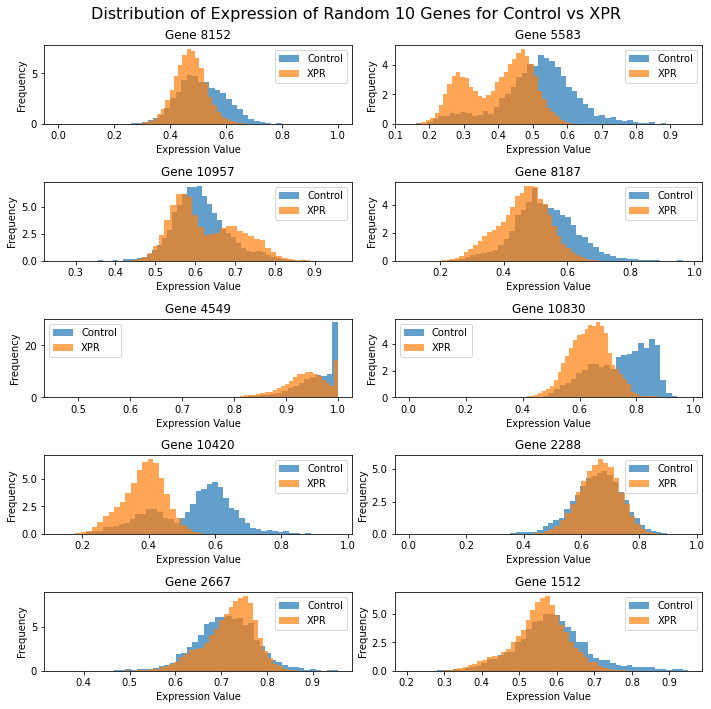

In [53]:
# now plot xpr and ctl on the same plot, normalized by n samples
plt.figure(figsize=(10, 10))
for i in range(gene_index.shape[0]):
    plt.subplot(5, 2, i+1)
    plt.hist(data_ctl[gene_index[i],:], bins=50, alpha=0.7, label='Control', density=True)
    plt.hist(data_xpr[gene_index[i],:], bins=50, alpha=0.7, label='XPR', density=True)
    plt.title(f'Gene {gene_index[i]}')
    # add large title
    plt.suptitle('Distribution of Expression of Random 10 Genes for Control vs XPR', fontsize=16)
    plt.xlabel('Expression Value')
    plt.ylabel('Frequency')
    plt.legend()
plt.tight_layout()
plt.savefig('/home/b-evelyntong/hl/lincs_lvl3_oe/processed_npz/xpr/A549_ctl_xpr_distribution.png')

In [56]:
# check the distribution of expression for ctrl vs xpr and ctrl vs oe
# A549
data_ctl = np.load('/home/b-evelyntong/hl/lincs_lvl3_oe/processed_npz/oe/cell_line_A549_pert_ctl_vector.npz', allow_pickle=True)
data_ctl = data_ctl['data']
data_oe = np.load('/home/b-evelyntong/hl/lincs_lvl3_oe/processed_npz/oe/cell_line_A549_pert_trt_oe.npz', allow_pickle=True)
data_oe = data_oe['data']

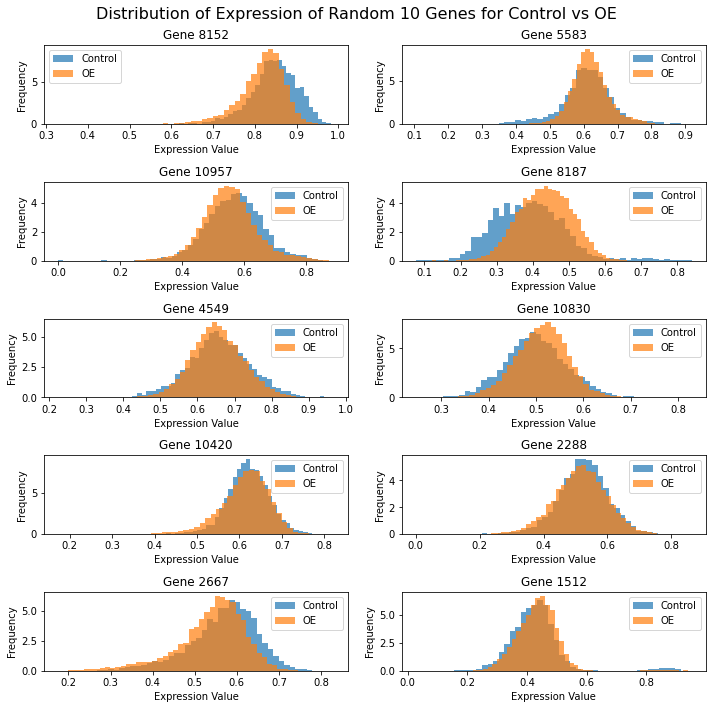

In [57]:
# now plot xpr and ctl on the same plot, normalized by n samples
plt.figure(figsize=(10, 10))
for i in range(gene_index.shape[0]):
    plt.subplot(5, 2, i+1)
    plt.hist(data_ctl[gene_index[i],:], bins=50, alpha=0.7, label='Control', density=True)
    plt.hist(data_oe[gene_index[i],:], bins=50, alpha=0.7, label='OE', density=True)
    plt.title(f'Gene {gene_index[i]}')
    plt.suptitle('Distribution of Expression of Random 10 Genes for Control vs OE', fontsize=16)
    plt.xlabel('Expression Value')
    plt.ylabel('Frequency')
    plt.legend()
plt.tight_layout()
plt.savefig('/home/b-evelyntong/hl/lincs_lvl3_oe/processed_npz/xpr/A549_ctl_oe_distribution.png')

In [162]:
# next, find a single sample that was originally incorrectly predicted by baseline, but correctly predicted by modified
# we find it for A375 oe
mod_pred = torch.load("/home/b-evelyntong/hl/modified_preds.pt")
baseline_pred = torch.load("/home/b-evelyntong/hl/baseline_preds.pt")
ground_truth = torch.load("/home/b-evelyntong/hl/ground_truths.pt")

In [151]:
pred = mod_pred
ls = []
for i in range(len(ground_truth)):
    intervention = ground_truth[i]
    pred_intervention = pred[i]
    pred_intervention = pred_intervention.squeeze(-1)
    correct_interventions = (intervention == 1).nonzero(as_tuple=True)[0]

    predicted_ranking = torch.argsort(pred_intervention, descending=True) 
    
    for gt_idx in correct_interventions:
        rank_position = (predicted_ranking == gt_idx).nonzero(as_tuple=True)[0].item()
        if rank_position == 1:
            ls.append((i, gt_idx, rank_position))
print(len(ls))

1


In [154]:
pred = baseline_pred
i = 3238
intervention = ground_truth[i]
pred_intervention = pred[i]
pred_intervention = pred_intervention.squeeze(-1)
correct_interventions = (intervention == 1).nonzero(as_tuple=True)[0]

predicted_ranking = torch.argsort(pred_intervention, descending=True) 
for gt_idx in correct_interventions:
    rank_position = (predicted_ranking == gt_idx).nonzero(as_tuple=True)[0].item()
print(rank_position)

4622


Wilcoxon test p-value: 0
T-test p-value: 0


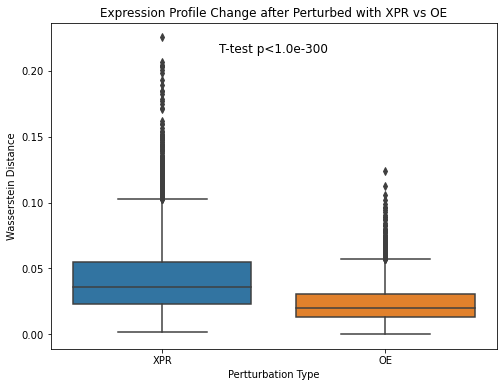

In [23]:
# check the distribution of expression for ctrl vs xpr and ctrl vs oe
# A549
data_ctl = np.load('/home/b-evelyntong/hl/lincs_lvl3_oe/processed_npz/xpr/cell_line_A375_pert_ctl_vector.npz', allow_pickle=True)
data_ctl = data_ctl['data']
data_xpr = np.load('/home/b-evelyntong/hl/lincs_lvl3_oe/processed_npz/xpr/cell_line_A375_pert_trt_xpr.npz', allow_pickle=True)
data_xpr = data_xpr['data']

wass_xpr = []
for i in range(data_ctl.shape[0]):
    a = data_ctl[i,:]
    b = data_xpr[i,:]
    wd = wasserstein_distance(a, b)
    wass_xpr.append(wd)

# check the distribution of expression for ctrl vs xpr and ctrl vs oe
# A549
data_ctl = np.load('/home/b-evelyntong/hl/lincs_lvl3_oe/processed_npz/oe/cell_line_A375_pert_ctl_vector.npz', allow_pickle=True)
data_ctl = data_ctl['data']
data_oe = np.load('/home/b-evelyntong/hl/lincs_lvl3_oe/processed_npz/oe/cell_line_A375_pert_trt_oe.npz', allow_pickle=True)
data_oe = data_oe['data']

wass_oe = []
for i in range(data_ctl.shape[0]):
    a = data_ctl[i,:]
    b = data_oe[i,:]
    wd = wasserstein_distance(a, b)
    wass_oe.append(wd)

df_plot = pd.DataFrame({
    'distance': np.concatenate([wass_xpr, wass_oe]),
    'group': ['XPR'] * len(wass_xpr) + ['OE'] * len(wass_oe)
})

# Wilcoxon rank-sum test (Mann-Whitney U)
stat, p_wilcox = mannwhitneyu(wass_xpr, wass_oe, alternative='two-sided')
print(f"Wilcoxon test p-value: {p_wilcox:.4g}")

# OR (optional) t-test
stat, p_ttest = ttest_ind(wass_xpr, wass_oe, equal_var=False)
print(f"T-test p-value: {p_ttest:.4g}")

plt.figure(figsize=(8,6))
sns.boxplot(x='group', y='distance', data=df_plot)
plt.title('Expression Profile Change after Perturbed with XPR vs OE')
display_p = max(p_wilcox, 1e-300)
plt.text(0.5, df_plot['distance'].max()*0.95, f'T-test p<{display_p:.1e}',
         ha='center', fontsize=12)
plt.xlabel('Pertturbation Type')
plt.ylabel('Wasserstein Distance')
plt.savefig('/home/b-evelyntong/hl/A375_wasserstein_distance.png')